In [2]:
import ast
import math
import json
import requests
import numpy as np
import pandas as pd
import plotly as py
import networkx as nx
import seaborn as sns
import ipywidgets as widgets

import statsmodels.api as sm
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from helpers import *
from scipy import stats
from datetime import datetime as dt
from ipywidgets import interact, interactive, fixed, interact_manual

from IPython.display import HTML
from plotly.subplots import make_subplots
from statsmodels.stats.multicomp import pairwise_tukeyhsd

py.offline.init_notebook_mode(connected=True)

# turn off warning
pd.options.mode.chained_assignment = None

In [3]:
#datapath
DATA_FOLDER = "./data/"
MOVIE_PATH=DATA_FOLDER+"CMU/movie.metadata.tsv"
CHARACTER_PATH = DATA_FOLDER+"CMU/character.metadata.tsv"

MOVIE_IMDB_PATH = DATA_FOLDER+"IMDB/title.basics.tsv"
MOVIE_IMDB_RATING_PATH = DATA_FOLDER+"IMDB/title.ratings.tsv"

In [4]:
# create dataframes

# define collumn names
colnames_movies = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "movie_name",
    "movie_release_date",
    "movie_box_office_revenue",
    "movie_runtime",
    "movie_languages",
    "movie_countries",
    "movie_genres",
]

colnames_character = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "last_update",
    "character_name",
    "actor_DOB",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age_at_movie_release",
    "freebase_character/actor_map_ID",
    "freebase_character_ID",
    "freebase_actor_ID",
]


# load data
movies = pd.read_csv(MOVIE_PATH, sep="\t", names=colnames_movies, header=None)
movies_original = movies.copy()
characters = pd.read_csv(
    CHARACTER_PATH, sep="\t", names=colnames_character, header=None
)


imdb_movies = pd.read_table(
    MOVIE_IMDB_PATH,
    sep="\t",
    usecols=["tconst", "originalTitle", "startYear", "runtimeMinutes"],
)
imdb_ratings = pd.read_table(MOVIE_IMDB_RATING_PATH, sep="\t")

In [5]:
#imbd movies already has the release date
#add release date to movies
movies["year_released"] = pd.to_datetime(
    movies["movie_release_date"], infer_datetime_format=True, errors="coerce"
).dt.year
#drop the rows with no release date in movies
movies = movies[~movies["year_released"].isna()]

#rename ccolumns to match between movies and imdb_movies
imdb_movies = imdb_movies.rename(
    columns={
        "startYear": "year_released",
        "originalTitle": "movie_name",
        "runtimeMinutes": "movie_runtime",
    }
)

# converting '\\N' values to np.nan
imdb_movies.loc[imdb_movies["year_released"] == "\\N", "year_released"] = np.nan
imdb_movies.loc[imdb_movies["movie_runtime"] == "\\N", "movie_runtime"] = np.nan

# removing all rows containing np.nan
imdb_movies = imdb_movies[imdb_movies["year_released"].notna()]

# converting year released to 'int64'
movies["year_released"] = movies["year_released"].astype("int64")
imdb_movies["year_released"] = imdb_movies["year_released"].astype("int64")

# converting runtime to 'float64'
imdb_movies["movie_runtime"] = imdb_movies["movie_runtime"].astype(
    "float64", errors="ignore"
)

# removing rows with duplicate of ('movie_name', 'release_year', 'movie_runtime') in movies
movies = movies.drop_duplicates(subset=["movie_name", "year_released", "movie_runtime"])
imdb_movies = imdb_movies.drop_duplicates(
    subset=["movie_name", "year_released", "movie_runtime"]
)


/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_49051/3628268272.py:3: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



In [6]:
#merge 'imdb_movies' with 'imdb_ratings':
imdb_movies = pd.merge(left=imdb_movies, right=imdb_ratings, on="tconst")

# merge 'movies' with 'imdb_movies' + 'imdb_ratings'
movies = pd.merge(
    left=movies,
    right=imdb_movies,
    how="left",
    on=["movie_name", "year_released", "movie_runtime"],
)


In [7]:
movies.head()

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56928.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,NaN,NaN,NaN
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17.0
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268.0
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997,NaN,NaN,NaN


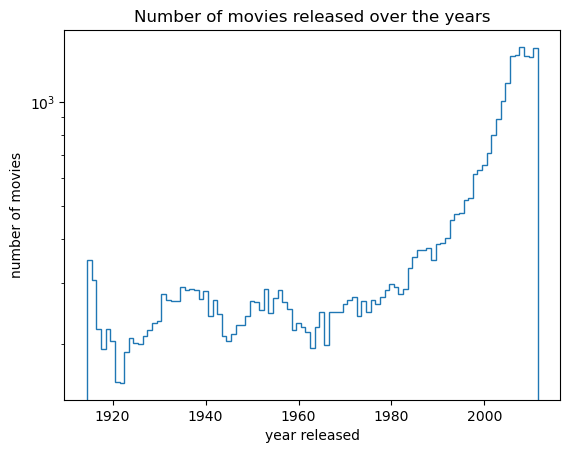

In [24]:
# plot the distribution of realese years
bins = np.arange(1915, 2013) - 0.5  # -0.5 for center-aligned bins
plt.hist(movies["year_released"], histtype="step", bins=bins, log=True)
plt.title("Number of movies released over the years")
plt.xlabel("year released")
plt.ylabel("number of movies")
plt.show()

In [19]:
#genres
genres = movies["movie_genres"].apply(ast.literal_eval).apply(pd.Series)


Series([], dtype: int64)

In [16]:
#duration
#the distribution of runtime and its correlation with rating
print(movies[["movie_runtime", "averageRating"]].count())
duration = movies[["movie_runtime", "averageRating"]].dropna()
duration.count()

movie_runtime    32661
averageRating    14369
dtype: int64


movie_runtime    13609
averageRating    13609
dtype: int64

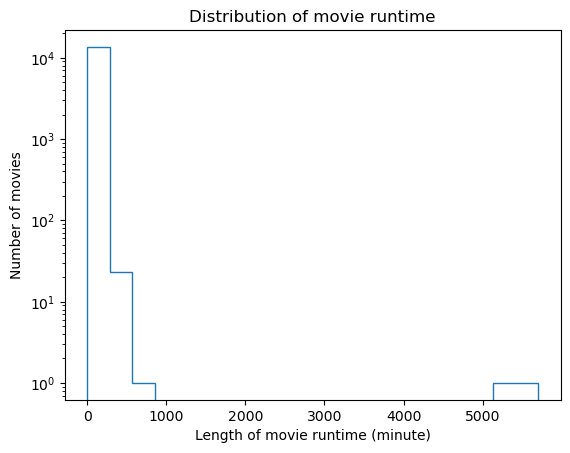

In [21]:
# histogram plot without removing outliers
plt.hist(duration["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()


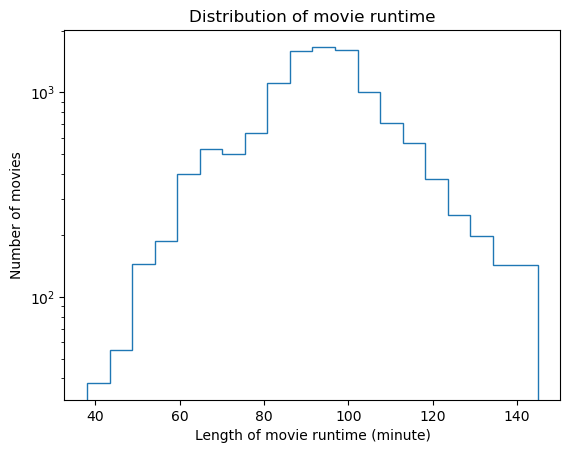

In [25]:
# histogram plot with removing outliers using IQR
q1 = duration["movie_runtime"].quantile(0.25)
q3 = duration["movie_runtime"].quantile(0.75)
iqr = q3 - q1
duration = duration[duration["movie_runtime"] < q3 + 1.5 * iqr]
duration = duration[duration["movie_runtime"] > q1 - 1.5 * iqr]

plt.hist(duration["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()
